# Download Dataset and Unzip the File

In [1]:
import urllib.request
import requests
import zipfile

zip_path = './data/'
zip_filename = 'sms+spam+collection.zip'

with zipfile.ZipFile(zip_path+zip_filename, 'r') as zip_ref:
    zip_ref.extractall(zip_path)

In [2]:
import pandas as pd 
df = pd.read_csv(zip_path+'SMSSpamCollection', sep="\t", header=None, names=["Label", "Text"] )

In [3]:
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
min_val_count = min(df['Label'].value_counts())
min_val_label = list(df['Label'].value_counts().keys())[df['Label'].value_counts().argmin()]

min_val_count,min_val_label

(747, 'spam')

In [5]:
df1 = df[df['Label'] == min_val_label]
df2 = df[df['Label'] != min_val_label]
df3 = df2.sample(n = min_val_count) 

In [6]:
df_new = pd.concat([df1,df3])
df_new.head()

,Label,Text
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


In [37]:
df_new = df_new.sample(frac=1).reset_index(drop=True)
df_new['Label'] = df_new["Label"].map({"ham": 0, "spam": 1})
df_new.head()

,Label,Text
0,1,Todays Vodafone numbers ending with 4882 are s...
1,0,Boy; I love u Grl: Hogolo Boy: gold chain kods...
2,1,Hi 07734396839 IBH Customer Loyalty Offer: The...
3,0,Wow. I never realized that you were so embaras...
4,1,We tried to contact you re your reply to our o...


In [38]:
train_frac = 0.7
val_frac = 0.1
test_frac = 0.2

train_len = int(0.7*len(df_new))
val_len = int(0.1*len(df_new))

df_train = df_new[0:train_len]
df_val = df_new[train_len:train_len+val_len]
df_test = df_new[train_len+val_len:]

len(df_train), len(df_val), len(df_test)

(1045, 149, 300)

# Creating DataLoader

In [39]:
import torch
import tiktoken
from torch.utils.data import Dataset

tokenizer = tiktoken.get_encoding("gpt2")

class SpamDataset(Dataset):

    def __init__(self,df,tokenizer,max_length = None, pad_token_id = 50256):
        super().__init__()

        self.data = df
        self.encoded_texts = [tokenizer.encode(text) for text in self.data['Text']]

        if max_length is None: 
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [ encoded_text[:self.max_length] for encoded_text in self.encoded_texts ]
        
        self.encoded_texts = [ encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts ]
    
    def __getitem__(self, index): 
        encoded = self.encoded_texts[index] 
        label = self.data.iloc[index]["Label"] 
        return ( 
            torch.tensor(encoded, dtype=torch.long), 
            torch.tensor(label, dtype=torch.long) 
            )
    
    def __len__(self): 
        return len(self.data)
    
    def _longest_encoded_length(self): 
        max_length = 0 
        for encoded_text in self.encoded_texts: 
            encoded_length = len(encoded_text) 
            if encoded_length > max_length: 
                max_length = encoded_length 
        return max_length

In [40]:
train_dataset = SpamDataset(df_train, max_length=None, tokenizer=tokenizer)
test_dataset = SpamDataset(df_test, max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset(df_val, max_length=None, tokenizer=tokenizer)

In [41]:
train_dataset.max_length

257

In [42]:
from torch.utils.data import DataLoader
num_workers = 2
batch_size = 8 
torch.manual_seed(123)

train_loader = DataLoader( dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader( dataset=val_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=False)
test_loader = DataLoader( dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=False, )

In [45]:
for input_batch, target_batch in train_loader: 
    pass 
print("Input batch dimensions:", input_batch.shape) 
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 257])
Label batch dimensions torch.Size([8])


In [86]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model_name = "gpt2"  # Use 'gpt2-medium', 'gpt2-large', or 'gpt2-xl' for larger models
#tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

In [77]:
BASE_CONFIG = { "vocab_size": 50257, "context_length": 1024, "drop_rate": 0.0, "qkv_bias": True }

def text_to_token_ids(text,tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

def generate_text_simple(model, idx, max_new_tokens, context_size): 
    for _ in range(max_new_tokens): 
        idx_cond = idx[:, -context_size:] 
        with torch.no_grad(): 
            outputs = model(idx_cond) 
            logits = outputs.logits
            logits = logits[:, -1, :] 
            probas = torch.softmax(logits, dim=-1) 
            idx_next = torch.argmax(probas, dim=-1, keepdim=True) 
            idx = torch.cat((idx, idx_next), dim=1)  
            return idx

In [78]:
text_1 = "Every effort moves you" 
token_ids = generate_text_simple( model=model, idx=text_to_token_ids(text_1, tokenizer), max_new_tokens=15, context_size=BASE_CONFIG["context_length"] )  
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward


In [79]:
for name, param in model.named_parameters():
    print(f"Layer: {name}")
    print(f"Shape: {param.shape}")
    print()


Layer: transformer.wte.weight
Shape: torch.Size([50257, 768])

Layer: transformer.wpe.weight
Shape: torch.Size([1024, 768])

Layer: transformer.h.0.ln_1.weight
Shape: torch.Size([768])

Layer: transformer.h.0.ln_1.bias
Shape: torch.Size([768])

Layer: transformer.h.0.attn.c_attn.weight
Shape: torch.Size([768, 2304])

Layer: transformer.h.0.attn.c_attn.bias
Shape: torch.Size([2304])

Layer: transformer.h.0.attn.c_proj.weight
Shape: torch.Size([768, 768])

Layer: transformer.h.0.attn.c_proj.bias
Shape: torch.Size([768])

Layer: transformer.h.0.ln_2.weight
Shape: torch.Size([768])

Layer: transformer.h.0.ln_2.bias
Shape: torch.Size([768])

Layer: transformer.h.0.mlp.c_fc.weight
Shape: torch.Size([768, 3072])

Layer: transformer.h.0.mlp.c_fc.bias
Shape: torch.Size([3072])

Layer: transformer.h.0.mlp.c_proj.weight
Shape: torch.Size([3072, 768])

Layer: transformer.h.0.mlp.c_proj.bias
Shape: torch.Size([768])

Layer: transformer.h.1.ln_1.weight
Shape: torch.Size([768])

Layer: transformer.h.

In [80]:
# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 124,439,808
Trainable parameters: 124,439,808


# Having the Classification Head

In [81]:
for param in model.parameters(): 
    param.requires_grad = False

In [87]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [88]:
torch.manual_seed(123) 
num_classes = 2 
BASE_CONFIG["emb_dim"] = 768
model.lm_head = torch.nn.Linear( in_features=BASE_CONFIG["emb_dim"], out_features=num_classes )

In [89]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=2, bias=True)
)


In [91]:
# Make the last transformer block as trainable
for param in model.transformer.h[-1].parameters(): 
    param.requires_grad = True 
for param in model.transformer.ln_f.parameters(): 
    param.requires_grad = True

In [92]:
inputs = tokenizer.encode("Do you have time") 
inputs = torch.tensor(inputs).unsqueeze(0) 
print("Inputs:", inputs) 
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [94]:
with torch.no_grad(): 
    outputs = model(inputs) 
    print("Outputs:\n", outputs.logits) 
    print("Outputs dimensions:", outputs.logits.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [99]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None): 
    model.eval() 
    correct_predictions, num_examples = 0, 0  
    if num_batches is None: 
        num_batches = len(data_loader) 
    else: 
        num_batches = min(num_batches, len(data_loader)) 
        for i, (input_batch, target_batch) in enumerate(data_loader): 
            if i < num_batches: 
                input_batch = input_batch.to(device) 
                target_batch = target_batch.to(device)  
                with torch.no_grad(): 
                    outputs = model(input_batch).logits[:, -1, :]
                    predicted_labels = torch.argmax(outputs, dim=-1)  
                    num_examples += predicted_labels.shape[0] 
                    correct_predictions += ((predicted_labels == target_batch).sum().item() )
            else:
                break
        
    return correct_predictions / num_examples

In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device)  
torch.manual_seed(123) 
train_accuracy = calc_accuracy_loader( train_loader, model, device, num_batches=10 )  
val_accuracy = calc_accuracy_loader( val_loader, model, device, num_batches=10 )  
test_accuracy = calc_accuracy_loader( test_loader, model, device, num_batches=10 )

In [101]:
print(f"Training accuracy: {train_accuracy*100:.2f}%") 
print(f"Validation accuracy: {val_accuracy*100:.2f}%") 
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 47.50%
Validation accuracy: 43.75%
Test accuracy: 48.75%


In [102]:
# Loss Function

def calc_loss_batch(input_batch, target_batch, model, device): 
    input_batch = input_batch.to(device) 
    target_batch = target_batch.to(device) 
    logits = model(input_batch).logits[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch) 
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None): 
    total_loss = 0. 
    if len(data_loader) == 0: 
        return float("nan") 
    elif num_batches is None: 
        num_batches = len(data_loader) 
    else: 
        num_batches = min(num_batches, len(data_loader)) 
        for i, (input_batch, target_batch) in enumerate(data_loader): 
            if i < num_batches: 
                loss = calc_loss_batch( input_batch, target_batch, model, device )  
                total_loss += loss.item() 
            else: 
                break 
    return total_loss / num_batches

In [103]:
with torch.no_grad(): 
    train_loss = calc_loss_loader( train_loader, model, device, num_batches=5 )  
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5) 
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5) 
    print(f"Training loss: {train_loss:.3f}") 
    print(f"Validation loss: {val_loss:.3f}") 
    print(f"Test loss: {test_loss:.3f}")

Training loss: 2.559
Validation loss: 3.077
Test loss: 3.088


In [107]:

def evaluate_model(model, train_loader, val_loader, device, eval_iter): 
    model.eval() 
    with torch.no_grad():
        train_loss = calc_loss_loader( train_loader, model, device, num_batches=eval_iter )  
        val_loss = calc_loss_loader( val_loader, model, device, num_batches=eval_iter )  
        model.train() 
        return train_loss, val_loss

def train_classifier_simple( model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter): 
    train_losses, val_losses, train_accs, val_accs = [], [], [], [] 
    examples_seen, global_step = 0, -1  
    for epoch in range(num_epochs): 
        model.train()  
        for input_batch, target_batch in train_loader: 
            optimizer.zero_grad() 
            loss = calc_loss_batch( input_batch, target_batch, model, device )  
            loss.backward() 
            optimizer.step() 
            examples_seen += input_batch.shape[0] 
            global_step += 1  
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model( model, train_loader, val_loader, device, eval_iter) 
                train_losses.append(train_loss) 
                val_losses.append(val_loss) 
                print(f"Ep {epoch+1} (Step {global_step:06d}): " f"Train loss {train_loss:.3f}, " f"Val loss {val_loss:.3f}" )  
                train_accuracy = calc_accuracy_loader( train_loader, model, device, num_batches=eval_iter )  
                val_accuracy = calc_accuracy_loader( val_loader, model, device, num_batches=eval_iter )  
                print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="") 
                print(f"Validation accuracy: {val_accuracy*100:.2f}%") 
                train_accs.append(train_accuracy) 
                val_accs.append(val_accuracy)  
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [109]:
import time  
start_time = time.time() 
torch.manual_seed(123) 
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1) 
num_epochs = 5  
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple( model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=50, eval_iter=5 )  
end_time = time.time() 
execution_time_minutes = (end_time - start_time) / 60 
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.366, Val loss 2.569
Training accuracy: 50.00% | Validation accuracy: 60.00%
Ep 1 (Step 000050): Train loss 0.577, Val loss 0.482
Training accuracy: 92.50% | Validation accuracy: 82.50%
Ep 1 (Step 000100): Train loss 0.040, Val loss 0.255
Training accuracy: 92.50% | Validation accuracy: 90.00%
Ep 2 (Step 000150): Train loss 0.236, Val loss 0.183
Training accuracy: 92.50% | Validation accuracy: 90.00%
Ep 2 (Step 000200): Train loss 0.106, Val loss 0.192
Training accuracy: 100.00% | Validation accuracy: 95.00%
Ep 2 (Step 000250): Train loss 0.096, Val loss 0.169
Training accuracy: 97.50% | Validation accuracy: 92.50%
Ep 3 (Step 000300): Train loss 0.071, Val loss 0.183
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 3 (Step 000350): Train loss 0.016, Val loss 0.059
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 4 (Step 000400): Train loss 0.028, Val loss 0.113
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 4 (Step 000450

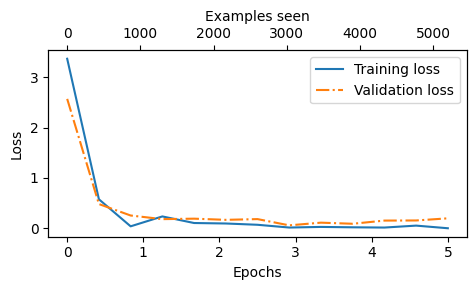

In [112]:
import matplotlib.pyplot as plt  
def plot_values( epochs_seen, examples_seen, train_values, val_values, label="loss"): 
    fig, ax1 = plt.subplots(figsize=(5, 3))  
    ax1.plot(epochs_seen, train_values, label=f"Training {label}") 
    ax1.plot( epochs_seen, val_values, linestyle="-.", label=f"Validation {label}" )  
    ax1.set_xlabel("Epochs") 
    ax1.set_ylabel(label.capitalize()) 
    ax1.legend()  
    ax2 = ax1.twiny() 
    ax2.plot(examples_seen, train_values, alpha=0) 
    ax2.set_xlabel("Examples seen")  
    fig.tight_layout() 
    plt.savefig(f"{label}-plot.pdf") 
    plt.show()  

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses)) 
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))  
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

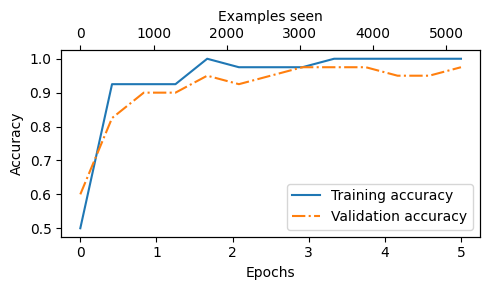

In [113]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs)) 
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))  
plot_values( epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy" )